# Försäljningsanalys för AdventureWorks2022

### Inledning 

I denna rapport presenteras en analys av försäljningsdata från AdventureWorks2022. Syftet med rapporten är att identifiera trender, avvikleser och mönster i försäljningsdatan och ge rekommendationer för framtida strategier. 

### Metod 

Analysen genomfördes genom att använda SQL-frågor för att extrahera data från AdventureWorks2022 databasen. Statistiksa beräkningar och grafer för visualisering. Fokus har lagts på följande områden:
* Försäljningstillväxten, månad-för-månad och år-för-år. 
* Kundernas köpbeteende och kategorisering.
* Försäljningsanalys för olika produktkategorier. 
* Försäljning per geografisk region.

Konfidensintervall för att beräkna genomsnittliga månatlig försäljningen


In [46]:
!pip install sqlalchemy
!pip install pyodbc

In [47]:
from sqlalchemy import create_engine, Table, inspect
from sqlalchemy import create_engine, func
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import seaborn as sns


In [48]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    
    return create_engine(eng)

In [49]:
engine = new_engine('mssql', 'TARAWILLIAM', 'AdventureWorks2022', integrated_security=True)

print(type(engine))

mssql://TARAWILLIAM/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server
<class 'sqlalchemy.engine.base.Engine'>


In [50]:
connection = engine.connect()
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


# 1. Metod SQL-queries, Satistiska beräkningar och Visualisering

### 1.1 Försäljningstillväxten, månad-för-månad och år-för-år.

In [51]:
# Sammanställning utav försäljningssiffror månad för månad för att se om företagets försäljningsintäkter ökar eller minskar

query_1 ="""
SELECT
    YEAR(OrderDate) AS År,
    MONTH(OrderDate) AS Månad,
    CONVERT(DECIMAL(10, 2), SUM(TotalDue)) AS Försäljningsintäkt
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY År, Månad ASC
"""
pd.read_sql(query_1, con=connection)


,År,Månad,Försäljningsintäkt
0,2011,5,567020.95
1,2011,6,507096.47
2,2011,7,2292182.88
3,2011,8,2800576.17
4,2011,9,554791.61
5,2011,10,5156269.53
6,2011,11,815313.02
7,2011,12,1462448.90
8,2012,1,4458337.44
9,2012,2,1649051.90


In [52]:
df = pd.read_sql(query_1, con=connection)
print(df.head())

     År  Månad  Försäljningsintäkt
0  2011      5           567020.95
1  2011      6           507096.47
2  2011      7          2292182.88
3  2011      8          2800576.17
4  2011      9           554791.61


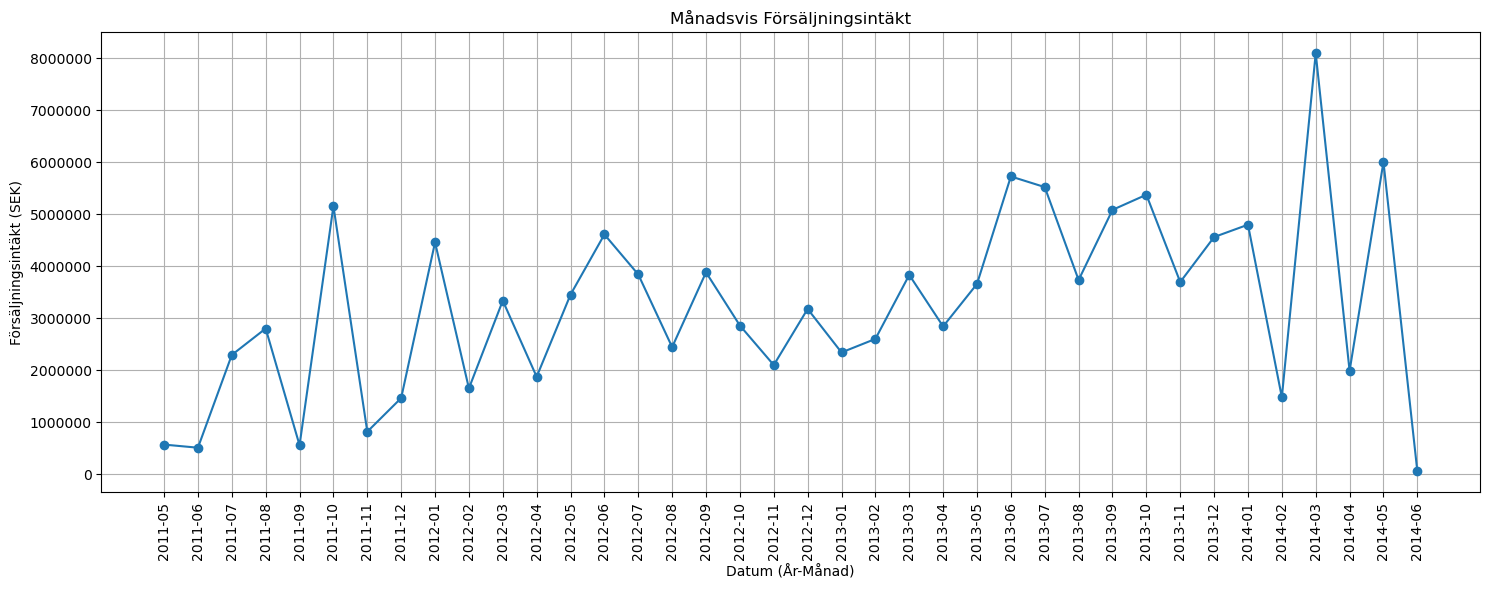

In [53]:
# 'YearMonth' kolumn för att användas på x-axeln
df['YearMonth'] = df['År'].astype(str) + '-' + df['Månad'].astype(str).str.zfill(2)

# Sortera data 
df.sort_values(by='YearMonth', inplace=True)

# Linjediagrammet
plt.figure(figsize=(15, 6))
plt.plot(df['YearMonth'], df['Försäljningsintäkt'], marker='o')
plt.ticklabel_format(style='plain', axis='y')

plt.title('Månadsvis Försäljningsintäkt')
plt.xlabel('Datum (År-Månad)')
plt.ylabel('Försäljningsintäkt (SEK)')
plt.xticks(rotation=90)  
plt.grid(True)
plt.tight_layout()  
plt.show()

### Konfidensintervall för att beräkna genomsnittliga månatlig försäljningen

In [54]:
df = pd.read_sql(query_1, con=connection)
df.head()

,År,Månad,Försäljningsintäkt
0,2011,5,567020.95
1,2011,6,507096.47
2,2011,7,2292182.88
3,2011,8,2800576.17
4,2011,9,554791.61


In [55]:
total_sale = df.Försäljningsintäkt

ci = stats.norm.interval(0.95, loc=np.mean(total_sale), scale=stats.sem(total_sale))

print(f"Konfidensintervall för genomsnittet: {ci}")

Konfidensintervall för genomsnittet: (2674150.8189485157, 3810943.186840959)


### Månatliga försäljningstillväxten

In [56]:
# Sammanställning utav försäljningstillväxt månad för månad, hur har tillväxten varit varje månad?
# Jag söker efter trender i den månatliga försäljningen, se om man kan hitta avvikelser för att anpassa inköp och lager men 
# även för att se om vi har stora skillnader i försäljningssiffrorna för att djupdyka mer och se vad det kan bero på!

multijoin_sql_1 = """
WITH Månatligfsg AS (
    SELECT
        YEAR(OrderDate) AS År,
        MONTH(OrderDate) AS Månad,
        CONVERT(DECIMAL(10, 2), SUM(TotalDue)) AS FörsäljningsIntäkt
    FROM Sales.SalesOrderHeader
    GROUP BY YEAR(OrderDate), MONTH(OrderDate)
)
SELECT 
    År,
    Månad, 
    FörsäljningsIntäkt,
    LAG(FörsäljningsIntäkt) OVER (ORDER BY År, Månad) AS TidigareMånad,
    CASE
        WHEN LAG(FörsäljningsIntäkt) OVER (ORDER BY År, Månad) IS NULL THEN NULL
        ELSE CONVERT(DECIMAL(10, 2), (FörsäljningsIntäkt - LAG(FörsäljningsIntäkt) OVER(ORDER BY År, Månad)) / LAG(FörsäljningsIntäkt) OVER(ORDER BY År, Månad))
    END AS FörsäljningsTillväxt
FROM Månatligfsg
ORDER BY År, Månad;

"""
pd.read_sql(sql=multijoin_sql_1, con=connection)


,År,Månad,FörsäljningsIntäkt,TidigareMånad,FörsäljningsTillväxt
0,2011,5,567020.95,NaN,NaN
1,2011,6,507096.47,567020.95,-0.11
2,2011,7,2292182.88,507096.47,3.52
3,2011,8,2800576.17,2292182.88,0.22
4,2011,9,554791.61,2800576.17,-0.80
5,2011,10,5156269.53,554791.61,8.29
6,2011,11,815313.02,5156269.53,-0.84
7,2011,12,1462448.90,815313.02,0.79
8,2012,1,4458337.44,1462448.90,2.05
9,2012,2,1649051.90,4458337.44,-0.63


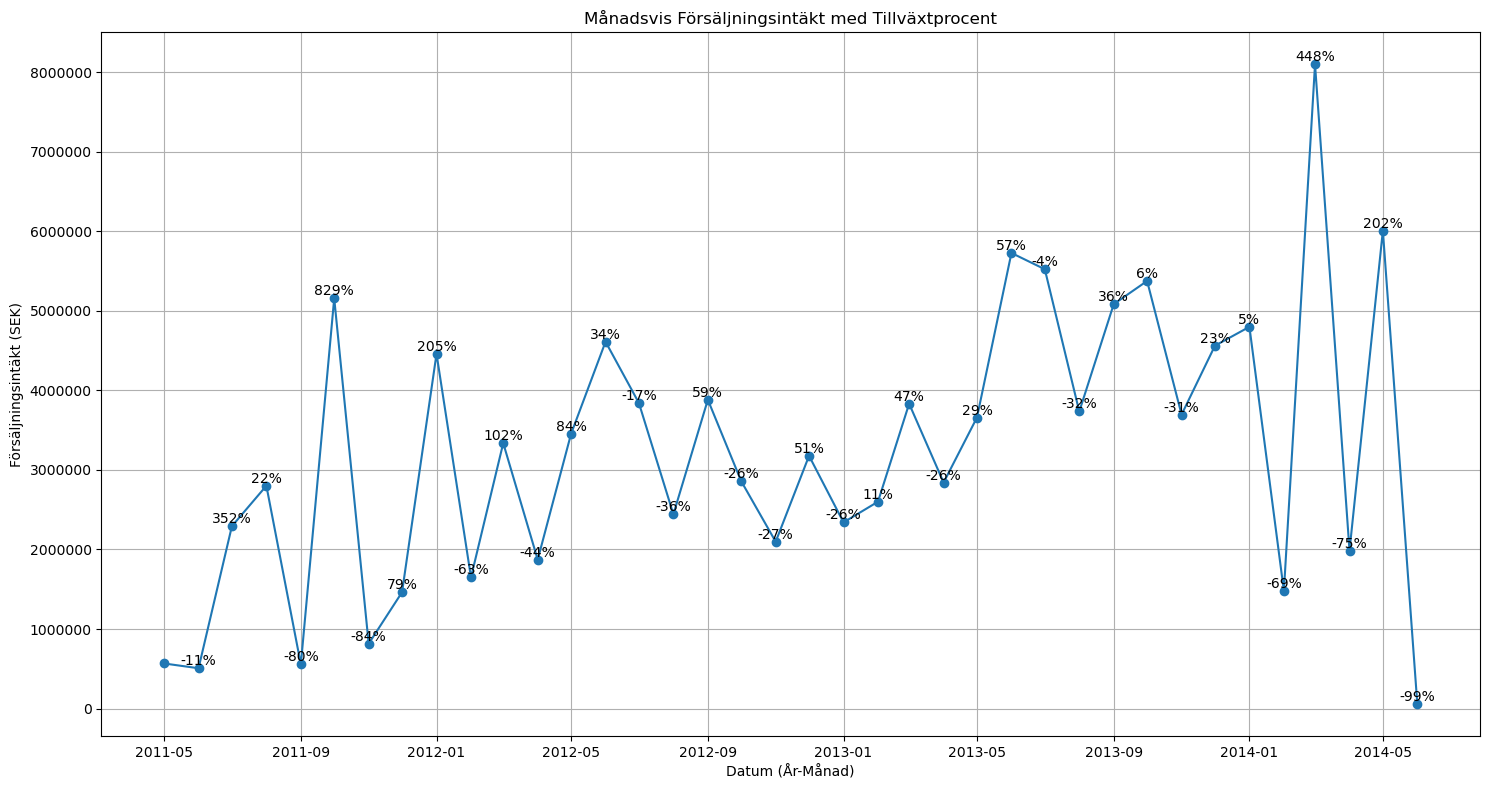

In [57]:
# DataFrame, databasen
df = pd.read_sql(multijoin_sql_1, con=connection) 

df['Datum'] = pd.to_datetime(df['År'].astype(str) + '-' + df['Månad'].astype(str))

# Sortera data enligt Datum
df.sort_values('Datum', inplace=True)

# Linjediagrammet
plt.figure(figsize=(15, 8))
plt.plot(df['Datum'], df['FörsäljningsIntäkt'], marker='o')

# Lägg till procentandelar på datapunkterna
for x, y, pct in zip(df['Datum'], df['FörsäljningsIntäkt'], df['FörsäljningsTillväxt']):
    label = "{:.0%}".format(pct) if pd.notnull(pct) else ""
    plt.text(x, y, label, ha='center', va='bottom')

plt.title('Månadsvis Försäljningsintäkt med Tillväxtprocent')
plt.xlabel('Datum (År-Månad)')
plt.ylabel('Försäljningsintäkt (SEK)')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
# Sammanställning utav försäljningstillväxt År för år, hur har tillväxten varit varje År?
# Efter att ha identifierat tillväxten månad för månad vill jag även se hur den årliga varit för att få en 
# överblick om företaget växer.

multijoin_sql_2 = """
WITH Årligfsg AS (
    SELECT
        YEAR(OrderDate) AS År,
        CONVERT(DECIMAL(10, 2), SUM(TotalDue)) AS Försäljningsintäkt
    FROM Sales.SalesOrderHeader
    GROUP BY YEAR(OrderDate)
)
SELECT 
    År, 
    Försäljningsintäkt,
    LAG(Försäljningsintäkt) OVER (ORDER BY År) AS 'Tidigare År',
    CASE
        WHEN LAG(Försäljningsintäkt) OVER (ORDER BY År) IS NULL THEN NULL
        ELSE CONVERT(DECIMAL(10, 2), (Försäljningsintäkt - LAG(Försäljningsintäkt) OVER(ORDER BY År)) / LAG(Försäljningsintäkt) OVER(ORDER BY År))
    END AS Försäljningstillväxt
FROM Årligfsg
ORDER BY År;
"""
pd.read_sql(sql=multijoin_sql_2, con=connection)


,År,Försäljningsintäkt,Tidigare År,Försäljningstillväxt
0,2011,14155699.53,NaN,NaN
1,2012,37675700.31,14155699.53,1.66
2,2013,48965887.96,37675700.31,0.30
3,2014,22419498.32,48965887.96,-0.54


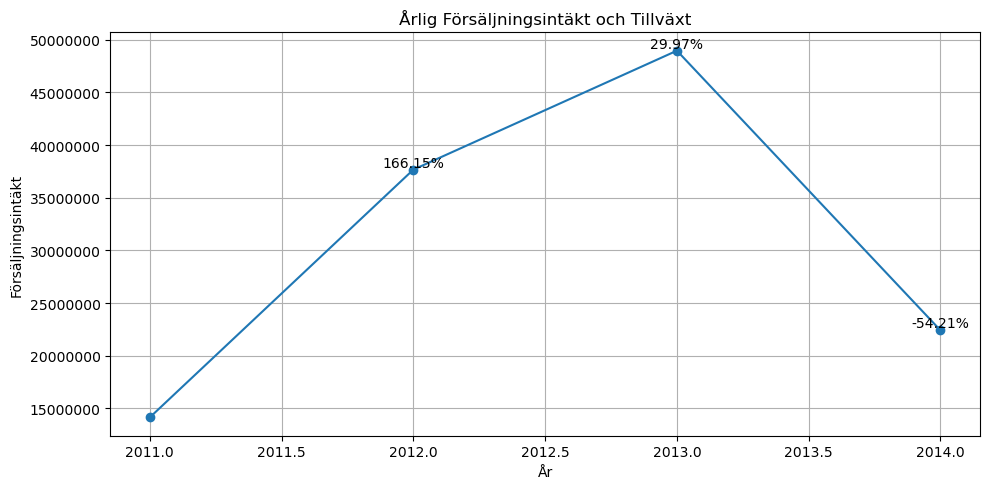

In [59]:
# DataFrame, databasen
df = pd.read_sql(multijoin_sql_2, con=connection) 

df['Tidigare År'] = df['Försäljningsintäkt'].shift(1)
df['Försäljningstillväxt'] = (df['Försäljningsintäkt'] - df['Tidigare År']) / df['Tidigare År']

# Linjediagrammet
plt.figure(figsize=(10, 5))
plt.plot(df['År'], df['Försäljningsintäkt'], marker='o')
plt.title('Årlig Försäljningsintäkt och Tillväxt')
plt.xlabel('År')
plt.ylabel('Försäljningsintäkt')
plt.ticklabel_format(style='plain', axis='y')

# Lägg till textetiketter för procentuell tillväxt
for i, row in df.iterrows():
    if not pd.isnull(row['Försäljningstillväxt']):
        plt.text(row['År'], row['Försäljningsintäkt'], f"{row['Försäljningstillväxt']:.2%}", ha='center', va='bottom')

# Visa diagrammet
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.2 Kundernas köpbeteende och kategorisering.

In [60]:
# Kunders Köpbeteende för att kategorisera och identifiera våra Stora, Medel och små kunder. 
# Bra för framtida planerade kundaktiviter för att maximera och effektivisera företagets försäljningsstrategier

multijoin_sql_3 = """
SELECT 
    A.CustomerID AS 'Kund ID',
    A.PersonID AS 'Personal ID',
    A.StoreID AS 'Butik',
    A.TerritoryID,
    COUNT(B.SalesOrderID) AS 'Antal Ordrar',
    CONVERT(DECIMAL(10, 2), SUM(B.TotalDue)) AS 'Kund Intäkt',
    CASE
        WHEN SUM(B.TotalDue) > 100000 THEN 'Stor Kund'
        WHEN SUM(B.TotalDue) BETWEEN 10000 AND 100000 THEN 'Medel Kund' 
        ELSE 'Liten Kund'
    END AS 'Kund Kategori'
FROM Sales.Customer AS A
    INNER JOIN Sales.SalesOrderHeader AS B ON A.CustomerID = B.CustomerID
GROUP BY A.CustomerID, A.PersonID, A.StoreID, A.TerritoryID
ORDER BY 'Kund Intäkt' DESC;
"""

pd.read_sql(sql=multijoin_sql_3, con=connection)

,Kund ID,Personal ID,Butik,TerritoryID,Antal Ordrar,Kund Intäkt,Kund Kategori
0,29818,1031,1032.0,1,12,989184.08,Stor Kund
1,29715,813,814.0,5,12,961675.86,Stor Kund
2,29722,827,828.0,6,12,954021.92,Stor Kund
3,30117,1991,1992.0,4,12,919801.82,Stor Kund
4,29614,591,592.0,6,12,901346.86,Stor Kund
...,...,...,...,...,...,...,...
19114,28016,14258,NaN,4,1,2.53,Liten Kund
19115,28093,9388,NaN,1,1,2.53,Liten Kund
19116,28094,8212,NaN,1,1,2.53,Liten Kund
19117,28095,2752,NaN,1,1,2.53,Liten Kund


In [61]:
df = pd.read_sql(multijoin_sql_3, con=connection) 
customer_counts = df['Kund Kategori'].value_counts()
print(customer_counts)

Liten Kund    18614
Stor Kund       254
Medel Kund      251
Name: Kund Kategori, dtype: int64


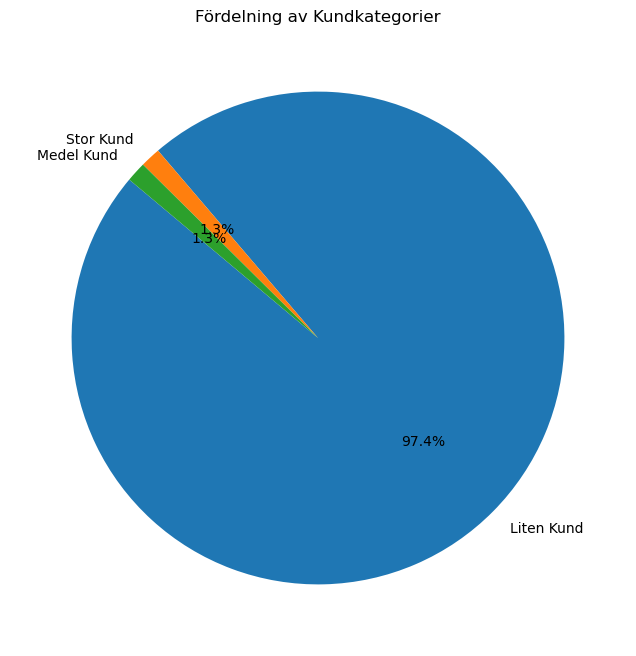

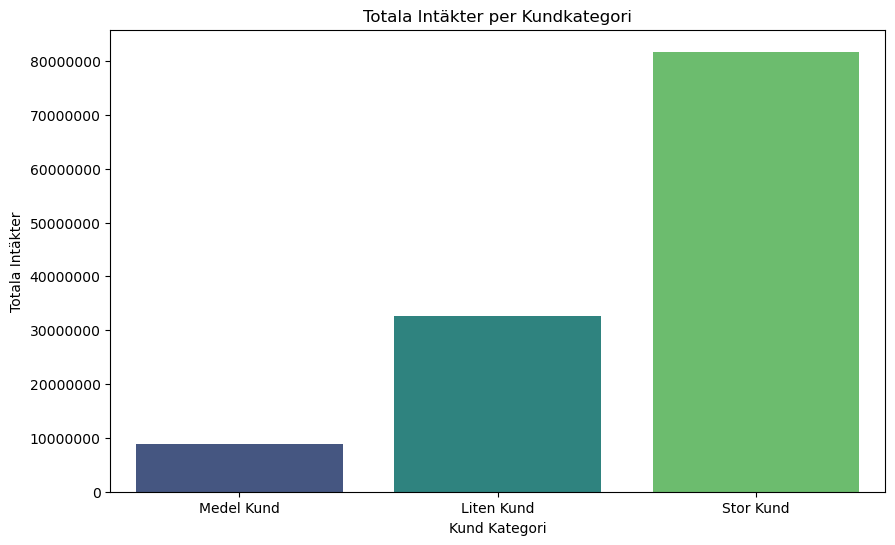

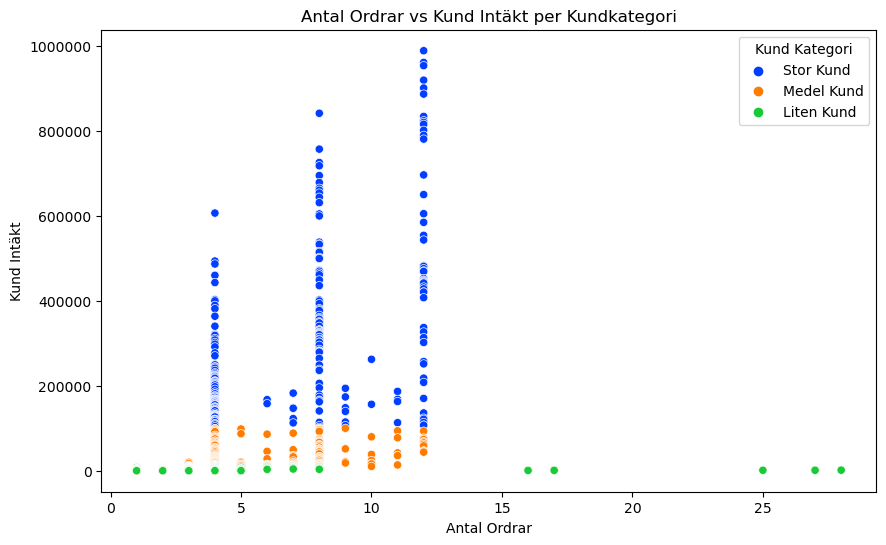

In [62]:
# DataFrame, databasen
df = pd.read_sql(multijoin_sql_3, con=connection) 

# Antalet kunder i varje kategori
customer_counts = df['Kund Kategori'].value_counts()

# Tårtdiagram för att visa fördelningen av kundkategorier
plt.figure(figsize=(8, 8))
customer_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Fördelning av Kundkategorier')
plt.ylabel('')  
plt.show()

# Stapeldiagram för att visa totala intäkter per kundkategori
revenue_per_category = df.groupby('Kund Kategori')['Kund Intäkt'].sum().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_per_category.index, y=revenue_per_category.values, palette='viridis')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Totala Intäkter per Kundkategori')
plt.xlabel('Kund Kategori')
plt.ylabel('Totala Intäkter')
plt.show()

# Scatterplot för att visa antal ordrar jämfört med kundintäkt per kundkategori
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Antal Ordrar', y='Kund Intäkt', hue='Kund Kategori', palette='bright')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Antal Ordrar vs Kund Intäkt per Kundkategori')
plt.xlabel('Antal Ordrar')
plt.ylabel('Kund Intäkt')
plt.legend(title='Kund Kategori')
plt.show()


### 1.3 Försäljningsanalys för olika produktkategorier.

In [63]:
# Produkter som säljs bäst, jag ville se vilka produkter företaget säljer allra bäst. 
# På så sätt kan vi se vad som går bra och vad som går mindre bra, var behöver vi lägga in resurser

multijoin_sql_4 = """
WITH ProduktFsg AS (
    SELECT 
        D.Name AS ProduktKategori,
        CONVERT(DECIMAL(10, 2), SUM(A.LineTotal)) AS FörsäljningsIntäkt
    FROM Sales.SalesOrderDetail AS A
    INNER JOIN Production.Product AS B ON A.ProductID = B.ProductID
    INNER JOIN Production.ProductSubcategory AS C ON B.ProductSubcategoryID = C.ProductSubcategoryID
    INNER JOIN Production.ProductCategory AS D ON C.ProductCategoryID = D.ProductCategoryID
    GROUP BY D.Name
)
SELECT 
    ProduktKategori,
    FörsäljningsIntäkt,
    ROW_NUMBER() OVER (ORDER BY FörsäljningsIntäkt DESC) AS Rankning
FROM ProduktFsg;
"""

pd.read_sql(sql=multijoin_sql_4, con=connection)

,ProduktKategori,FörsäljningsIntäkt,Rankning
0,Bikes,94651172.70,1
1,Components,11802593.29,2
2,Clothing,2120542.52,3
3,Accessories,1272072.88,4


### 1.4 Försäljning per geografisk region.

I detta steg vill jag se vilka regioner som säljer bästa, för att få en överblick i var vi presterar bättre eller mindre bra,
Identifiera variationer för att skapa marknadsföringskampanjer för att t.ex. utöka vår synlighet.
Är det andra brister som vi behöver uppmärksamma och på så sätt se vilka insatser behöver sättas in! 

In [64]:
# Jag börjar med att tittat på Gegrafiska regioner som helhet och vill få fram den Totala Försäljningen över tid 
 
query_2 = """
SELECT 
    B.Name AS Region,
    CONVERT(DECIMAL(10, 2), SUM(A.TotalDue)) AS FörsäljningsIntäkt
FROM Sales.SalesOrderHeader AS A
    INNER JOIN Sales.SalesTerritory AS B ON A.TerritoryID = B.TerritoryID
GROUP BY B.Name
ORDER BY FörsäljningsIntäkt DESC;
"""
pd.read_sql(sql=query_2, con=connection)

,Region,FörsäljningsIntäkt
0,Southwest,27150594.59
1,Canada,18398929.19
2,Northwest,18061660.37
3,Australia,11814376.10
4,Central,8913299.25
5,Southeast,8884099.37
6,United Kingdom,8574048.71
7,France,8119749.35
8,Northeast,7820209.63
9,Germany,5479819.58


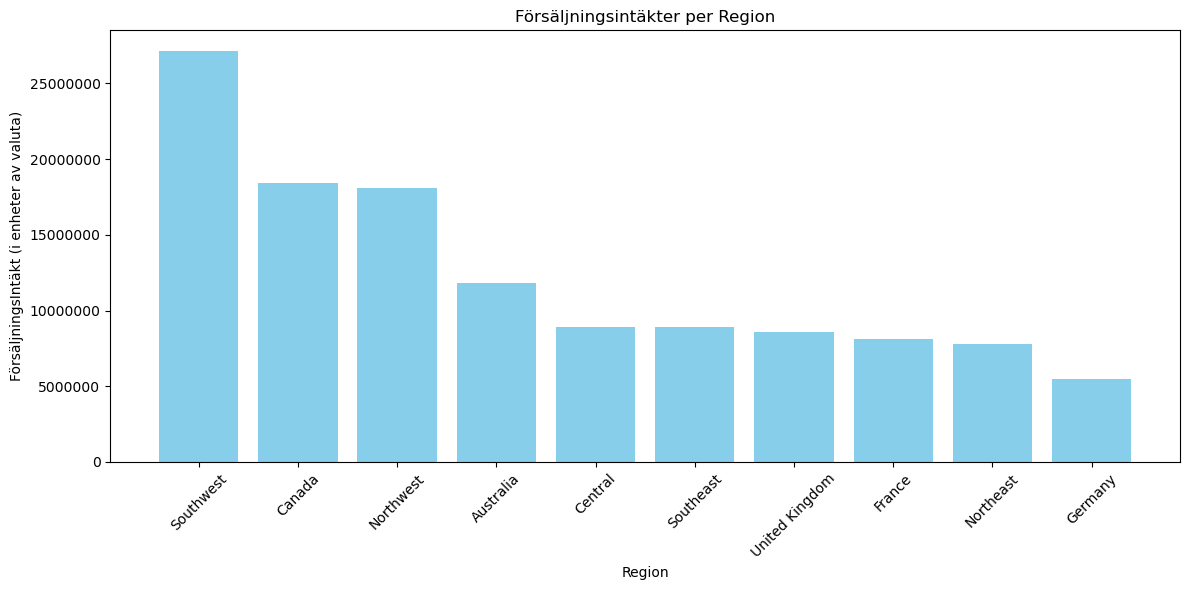

In [65]:
df = pd.read_sql(sql=query_2, con=connection)

# Skapa ett stapeldiagram
plt.figure(figsize=(12, 6))
plt.bar(df['Region'], df['FörsäljningsIntäkt'], color='skyblue')
plt.title('Försäljningsintäkter per Region')
plt.xlabel('Region')
plt.ylabel('FörsäljningsIntäkt (i enheter av valuta)')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()  # Justera layouten för att passa x-axel etiketterna
plt.show()

In [66]:
# Utifrån ovan resultat vill jag djupduka i varje Land för sig och få ha en sammanställning utav månatliga 
# försäljningstillväxten efter Region
# Jag vill se vilka länder har en stark tillväxt och vilka länder säljer sämre, för att se Trender och avvikleser.

multijoin_sql_5 = """
WITH MånRegionFsg AS (
    SELECT 
        B.Name AS Land,
        YEAR(A.OrderDate) AS År,
        MONTH(A.OrderDate) AS Månad,
        CONVERT(DECIMAL(10, 2), SUM(A.TotalDue)) AS FörsäljningsIntäkt
    FROM Sales.SalesOrderHeader AS A 
    JOIN Sales.SalesTerritory AS B ON A.TerritoryID = B.TerritoryID
    GROUP BY B.Name, YEAR(A.OrderDate), MONTH(A.OrderDate)
)
SELECT
    Land,
    År,
    Månad,
    FörsäljningsIntäkt,
    LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År, Månad) AS TidigareÅrFsg,
    CASE
        WHEN LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År, Månad) = 0 THEN NULL
        ELSE CONVERT(DECIMAL(10, 2), (FörsäljningsIntäkt - LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År, Månad)) / LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År, Månad))
    END AS FörsäljningsTillväxt
FROM MånRegionFsg 
ORDER BY Land, År, Månad;
"""

pd.read_sql(sql=multijoin_sql_5, con=connection)

,Land,År,Månad,FörsäljningsIntäkt,TidigareÅrFsg,FörsäljningsTillväxt
0,Australia,2011,5,3756.99,NaN,NaN
1,Australia,2011,6,227909.47,3756.99,59.66
2,Australia,2011,7,245904.81,227909.47,0.08
3,Australia,2011,8,196019.82,245904.81,-0.20
4,Australia,2011,9,237125.70,196019.82,0.21
...,...,...,...,...,...,...
359,United Kingdom,2014,2,194241.77,582314.99,-0.67
360,United Kingdom,2014,3,555453.99,194241.77,1.86
361,United Kingdom,2014,4,228128.92,555453.99,-0.59
362,United Kingdom,2014,5,770361.43,228128.92,2.38


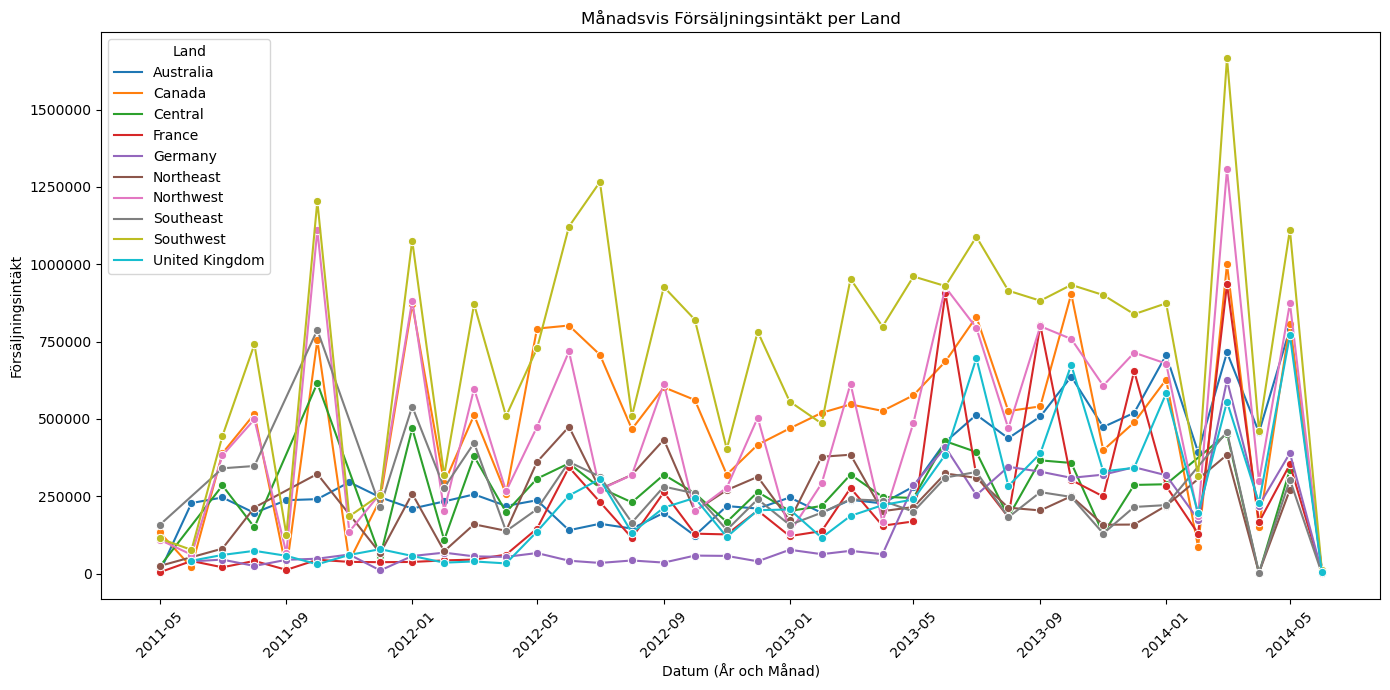

In [76]:
df = pd.read_sql(sql=multijoin_sql_5, con=connection)

df['YearMonth'] = pd.to_datetime(df['År'].astype(str) + df['Månad'].astype(str), format='%Y%m')

df.sort_values(by=['Land', 'YearMonth'], inplace=True)

# Nu kan vi plotta data med Seaborn eller Matplotlib
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='YearMonth', y='FörsäljningsIntäkt', hue='Land', marker='o')

plt.title('Månadsvis Försäljningsintäkt per Land')
plt.xlabel('Datum (År och Månad)')
plt.ylabel('Försäljningsintäkt')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.legend(title='Land')
plt.tight_layout()
plt.show()

In [77]:
# Sammanställning utav den årliga försäljningstillväxten efter Land.

multijoin_sql_6 = """
WITH ÅrligRegionalFörsäljning AS (
    SELECT 
        B.Name AS Land,
        YEAR(A.OrderDate) AS År,
        CONVERT(DECIMAL(10, 2), SUM(A.TotalDue)) AS FörsäljningsIntäkt
    FROM Sales.SalesOrderHeader AS A
    INNER JOIN Sales.SalesTerritory AS B ON A.TerritoryID = B.TerritoryID
    GROUP BY B.Name, YEAR(A.OrderDate)
)
SELECT
    Land,
    År,
    FörsäljningsIntäkt,
    LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År) AS TidigareÅrFsg,
    CASE
        WHEN LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År) = 0 THEN NULL
        ELSE CONVERT(DECIMAL(10, 2), (FörsäljningsIntäkt - LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År)) / LAG(FörsäljningsIntäkt) OVER (PARTITION BY Land ORDER BY År))
    END AS FörsäljningsTillväxt
FROM ÅrligRegionalFörsäljning
ORDER BY Land, År;

"""

pd.read_sql(sql=multijoin_sql_6, con=connection)

,Land,År,FörsäljningsIntäkt,TidigareÅrFsg,FörsäljningsTillväxt
0,Australia,2011,1693032.74,NaN,NaN
1,Australia,2012,2347885.46,1693032.74,0.39
2,Australia,2013,4702404.05,2347885.46,1.00
3,Australia,2014,3071053.84,4702404.05,-0.35
4,Canada,2011,2106905.87,NaN,NaN
5,Canada,2012,6599971.02,2106905.87,2.13
6,Canada,2013,7010449.70,6599971.02,0.06
7,Canada,2014,2681602.59,7010449.70,-0.62
8,Central,2011,1126645.75,NaN,NaN
9,Central,2012,3334867.98,1126645.75,1.96


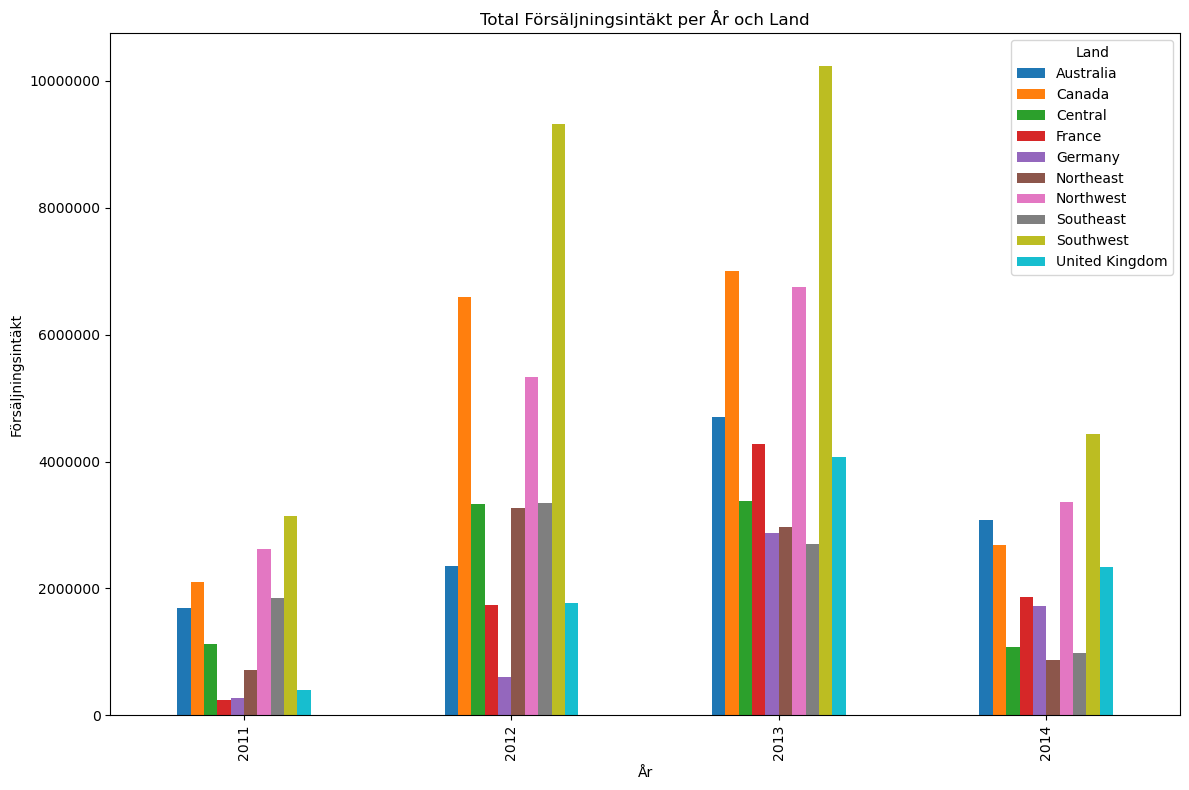

In [80]:
df = pd.read_sql(sql=multijoin_sql_6, con=connection)
df.sort_values(by=['Land', 'År'], inplace=True)

# pivot-tabell
pivot_df = df.pivot(index='År', columns='Land', values='FörsäljningsIntäkt')

pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Total Försäljningsintäkt per År och Land')
plt.xlabel('År')
plt.ylabel('Försäljningsintäkt')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Land')
plt.tight_layout()
plt.show()

### 2. Konfidensintervall för att beräkna genomsnittliga månatlig försäljningen


In [28]:
df = pd.read_sql(multijoin_sql_1, con=connection)
df.head(10)

,År,Månad,FörsäljningsIntäkt,TidigareMånad,FörsäljningsTillväxt
0,2011,5,567020.95,NaN,NaN
1,2011,6,507096.47,567020.95,-0.11
2,2011,7,2292182.88,507096.47,3.52
3,2011,8,2800576.17,2292182.88,0.22
4,2011,9,554791.61,2800576.17,-0.80
5,2011,10,5156269.53,554791.61,8.29
6,2011,11,815313.02,5156269.53,-0.84
7,2011,12,1462448.90,815313.02,0.79
8,2012,1,4458337.44,1462448.90,2.05
9,2012,2,1649051.90,4458337.44,-0.63


In [81]:
order_amounts = df.FörsäljningsIntäkt

ci = stats.norm.interval(0.95, loc=np.mean(order_amounts), scale=stats.sem(order_amounts))

print(f"Konfidensintervall för genomsnittet: {ci}")

Konfidensintervall för genomsnittet: (2363479.661896213, 3797359.645103788)
